# USD/JPY LSTM(TensorFlow)

In [18]:
%tensorflow_version 1.x

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set()

## データ読み込み

In [20]:
!mkdir data
!wget https://dl.dropbox.com/s/rzzcc89lokvzu3r/usd_jpy.csv -O data/usd_jpy.csv

mkdir: cannot create directory ‘data’: File exists
--2020-10-11 23:57:39--  https://dl.dropbox.com/s/rzzcc89lokvzu3r/usd_jpy.csv
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.65.15, 2620:100:6021:15::a27d:410f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.65.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/rzzcc89lokvzu3r/usd_jpy.csv [following]
--2020-10-11 23:57:39--  https://dl.dropboxusercontent.com/s/rzzcc89lokvzu3r/usd_jpy.csv
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6021:15::a27d:410f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107599 (105K) [text/csv]
Saving to: ‘data/usd_jpy.csv’

data/usd_jpy.csv    100%[===================>] 105.08K   516KB/s    in 0.2s    

2020-10-11 23:57:40 (516 KB/s) - ‘data/usd_jpy.csv’ saved [107599/107599]



In [21]:
df = pd.read_csv('data/usd_jpy.csv')
df.head()

,日付,始値,高値,安値,終値
0,2007/04/02,117.84,118.08,117.46,117.84
1,2007/04/03,117.84,118.98,117.72,118.96
2,2007/04/04,118.92,119.08,118.56,118.72
3,2007/04/05,118.72,118.99,118.44,118.72
4,2007/04/06,118.72,119.39,118.67,119.27


In [22]:
df.describe()

,始値,高値,安値,終値
count,2925.000000,2925.000000,2925.000000,2925.000000
mean,100.618236,101.057046,100.119538,100.615289
std,13.849288,13.881241,13.800449,13.851496
min,75.760000,75.980000,75.570000,75.680000
25%,89.690000,90.210000,89.120000,89.740000
50%,102.080000,102.440000,101.720000,102.090000
75%,111.700000,112.140000,111.170000,111.700000
max,125.660000,125.860000,124.540000,125.550000


([<matplotlib.axis.XTick at 0x7f65857e12e8>,
 [Text(0, 0, '2007/04/02'),
  Text(0, 0, '2008/04/02'),
  Text(0, 0, '2009/04/03'),
  Text(0, 0, '2010/04/05'),
  Text(0, 0, '2011/04/04'),
  Text(0, 0, '2012/04/03'),
  Text(0, 0, '2013/04/03'),
  Text(0, 0, '2014/04/03'),
  Text(0, 0, '2015/04/03'),
  Text(0, 0, '2016/04/04'),
  Text(0, 0, '2017/04/04'),
  Text(0, 0, '2018/04/04')])

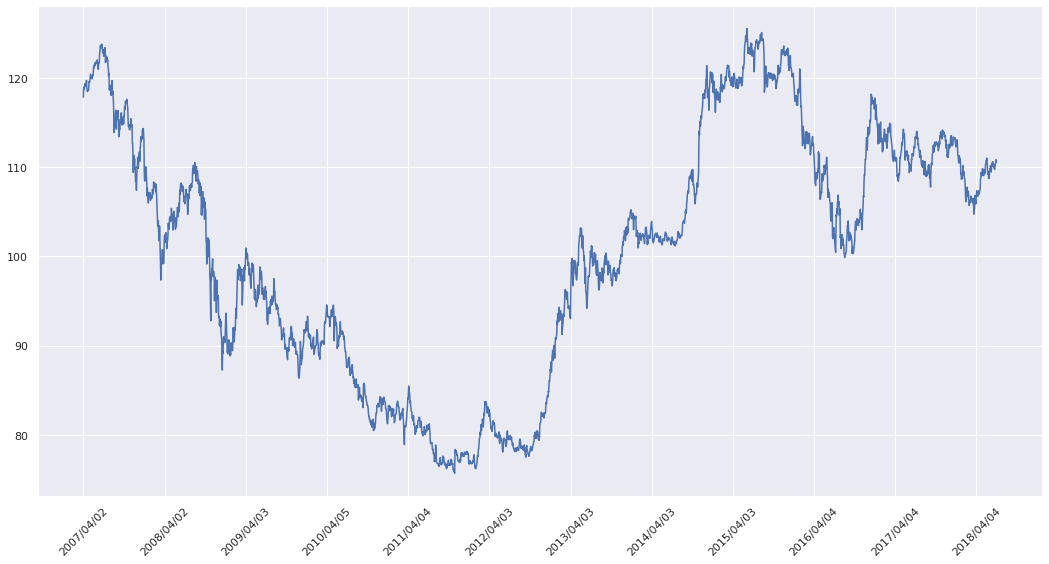

In [23]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(df.shape[0]), df['終値'].values)
plt.xticks(np.arange(0, df.shape[0], 260), df['日付'].loc[::260], rotation=45)

In [24]:
close_prices = df['終値'].values

train_ratio = 0.8
n_train = int(len(close_prices) * train_ratio)
train, test = close_prices[:n_train], close_prices[n_train:]
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

In [25]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [26]:
class DataGenerator():
    def __init__(self, data, batch_size, n_steps):
        self.data = data
        self.batch_size = batch_size
        self.n_steps = n_steps
        
        self.i = 0
        self.epoch = 0
        self.new_epoch = False
        
        self.perm = np.random.permutation(len(data) - self.n_steps)
    
    def next_batch(self):
        if self.new_epoch:
            self.new_epoch = False

        batch = []
        for _ in range(self.batch_size):
            self.i += 1
            if self.i >= len(self.perm):
                self.i %= len(self.perm)
                self.epoch += 1
                self.new_epoch = True

            idx = self.perm[self.i]
            batch.append(self.data[idx: idx+self.n_steps+1])
        batch = np.array(batch)
        return batch[:, :-1], batch[:, -1]  # x, y

In [27]:
# 学習設定
batch_size = 32    # ミニバッチサイズ
n_steps = 50       # 入力系列の長さ
input_size = 1     # 入力の次元
hidden_size = 50   #  中間層の次元
output_size = 1    # 出力層の次元

n_epochs = 30       # エポック数

In [28]:
train_gen = DataGenerator(train, batch_size, n_steps)

## モデル構築

In [29]:
def inference(x):
    """
    推論（順伝播）
    x: (batch_size, n_steps, input_size)
    """
    # static_rnn関数の引数に適切な形に変形
    x = tf.transpose(x, [1, 0, 2])  # (n_steps, batch_size, input_size)
    x = tf.reshape(x, [-1, input_size])  # (n_steps*batch_size, input_size)
    x = tf.split(x, n_steps, axis=0)  # [(batch_size, input_size)] * n_steps
    
    # RNN(LSTM)セルを定義
    # rnn_cell = tf.contrib.rnn.BasicRNNCell(hidden_size)
    rnn_cell = tf.contrib.rnn.BasicLSTMCell(hidden_size, forget_bias=1.0)
    
    # RNNセルを時間方向に伝播
    hs, _ = tf.contrib.rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    
    # 出力層の定義
    W_out = tf.Variable(tf.random_normal([hidden_size, output_size]))
    b_out = tf.Variable(tf.random_normal([output_size]))
    return tf.matmul(hs[-1], W_out) + b_out

In [30]:
tf.reset_default_graph()

# 入出力プレースホルダーの定義
x = tf.placeholder("float", [None, n_steps, input_size])
y = tf.placeholder("float", [None, output_size])

# オペレーションの定義
pred = inference(x)
loss = tf.losses.mean_squared_error(y, pred)
train_step = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


## 学習

In [31]:
init = tf.global_variables_initializer()
# セッション
sess = tf.Session()
# 変数初期化
sess.run(init)

while train_gen.epoch < n_epochs:
    batch_x, batch_y = train_gen.next_batch()
    feed_dict = {x: batch_x, y: batch_y}
    sess.run(train_step, feed_dict=feed_dict)
    if train_gen.new_epoch:
        l = sess.run(loss, feed_dict=feed_dict)
        print("epoch: {}, loss {:.5f}".format(train_gen.epoch, l))

epoch: 1, loss 0.00101
epoch: 2, loss 0.00081
epoch: 3, loss 0.00083
epoch: 4, loss 0.00057
epoch: 5, loss 0.00052
epoch: 6, loss 0.00046
epoch: 7, loss 0.00047
epoch: 8, loss 0.00046
epoch: 9, loss 0.00051
epoch: 10, loss 0.00047
epoch: 11, loss 0.00036
epoch: 12, loss 0.00033
epoch: 13, loss 0.00033
epoch: 14, loss 0.00030
epoch: 15, loss 0.00037
epoch: 16, loss 0.00032
epoch: 17, loss 0.00037
epoch: 18, loss 0.00039
epoch: 19, loss 0.00042
epoch: 20, loss 0.00031
epoch: 21, loss 0.00033
epoch: 22, loss 0.00027
epoch: 23, loss 0.00033
epoch: 24, loss 0.00032
epoch: 25, loss 0.00037
epoch: 26, loss 0.00035
epoch: 27, loss 0.00029
epoch: 28, loss 0.00032
epoch: 29, loss 0.00022
epoch: 30, loss 0.00032


## テスト

In [32]:
test_batch = []
for idx in range(len(test) - n_steps):
    test_batch.append(test[idx: idx+n_steps+1])
test_batch = np.array(test_batch)
x_test, y_test = test_batch[:, :-1], test_batch[:, -1]

In [33]:
# テストデータに対する予測
prediction = sess.run(pred, feed_dict={x: x_test})

prediction = prediction.reshape(-1, 1)
# 元のスケールに
prediction = scaler.inverse_transform(prediction)
y_test = scaler.inverse_transform(y_test)

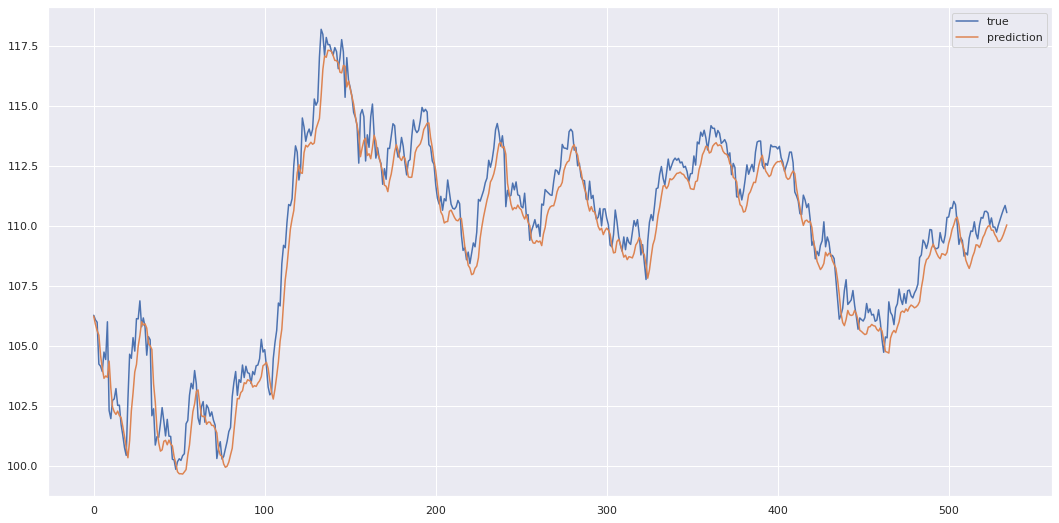

In [34]:
# テストデータに対する予測を可視化
xx = np.arange(len(prediction))
plt.figure(figsize=(18, 9))
plt.plot(xx, y_test, label='true')
plt.plot(xx, prediction, label='prediction')
plt.legend()